# Online Retail Data
This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company
mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. The project work consists of demonstrating an aspect of the course using the selected 'Online Retail' dataset.

## Data set description
- **Source:** UK-based online retailer (year 2010-2011)
- **Rows:** Each row represents a transaction.
- **Columns:**
  - `InvoiceNo`: Invoice number
  - `StockCode`: Product code
  - `Description`: Product description
  - `Quantity`: Number of items purchased
  - `InvoiceDate`: Date/time of the invoice
  - `UnitPrice`: Price per unit
  - `CustomerID`: Customer ID
  - `Country`: Country of the customer

---

# Import data

In [116]:
import pandas as pd
import numpy as np

file_path = 'Dataset_Online_Retail.csv'
df = pd.read_csv(file_path)

df_cleaned = df.copy()

df_cleaned.info()
df_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


---
# 1. Data Preprocessing

<h2 style="color:#d36c87;">1.1. Data cleaning</h2>

### Handling Missing Values

In [117]:
df_cleaned.isnull().sum()

df_cleaned = df_cleaned.dropna(subset=['CustomerID'])

### Remove Duplicates

In [118]:
df_cleaned = df_cleaned.drop_duplicates()

### Check and Convert Data Types

In [119]:
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

### Check Invalid Values

In [120]:
df_cleaned = df_cleaned[(df_cleaned['Quantity'] > 0) & (df_cleaned['UnitPrice'] > 0)]

### Identify and Remove Outliers

In [121]:
# Quantity Outliers
Q1_q = df_cleaned['Quantity'].quantile(0.25)
Q3_q = df_cleaned['Quantity'].quantile(0.75)
IQR_q = Q3_q - Q1_q
df_cleaned = df_cleaned[(df_cleaned['Quantity'] >= Q1_q - 1.5 * IQR_q) & (df_cleaned['Quantity'] <= Q3_q + 1.5 * IQR_q)]

#UnitPrice Outliers
Q1_p = df_cleaned['UnitPrice'].quantile(0.25)
Q3_p = df_cleaned['UnitPrice'].quantile(0.75)
IQR_p = Q3_p - Q1_p
df_cleaned = df_cleaned[(df_cleaned['UnitPrice'] >= Q1_p - 1.5 * IQR_p) & (df_cleaned['UnitPrice'] <= Q3_p + 1.5 * IQR_p)]

### Feature Engineering

In [122]:
# TotalPrice = Quantity * UnitPrice
df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

### Export Clean Dataset

In [123]:
df_cleaned.to_csv("Dataset_Online_Retail_Cleaned.csv", index=False)

<h2 style="color:#d36c87;">1.2. Data integration</h2>

In [124]:
numerical_df = df_cleaned[['Quantity', 'UnitPrice', 'CustomerID', 'TotalPrice']].dropna()

### Covariance & Correlation Analysis

Covariance Matrix:
               Quantity  UnitPrice    CustomerID   TotalPrice
Quantity      45.930945  -3.665583 -1.698719e+03    45.917542
UnitPrice     -3.665583   2.390161 -2.138029e+01     7.311779
CustomerID -1698.719018 -21.380289  2.928123e+06 -2798.113013
TotalPrice    45.917542   7.311779 -2.798113e+03   174.635352

--------------------------

Correlation Matrix:
            Quantity  UnitPrice  CustomerID  TotalPrice
Quantity    1.000000  -0.349846   -0.146479    0.512696
UnitPrice  -0.349846   1.000000   -0.008082    0.357885
CustomerID -0.146479  -0.008082    1.000000   -0.123738
TotalPrice  0.512696   0.357885   -0.123738    1.000000

--------------------------



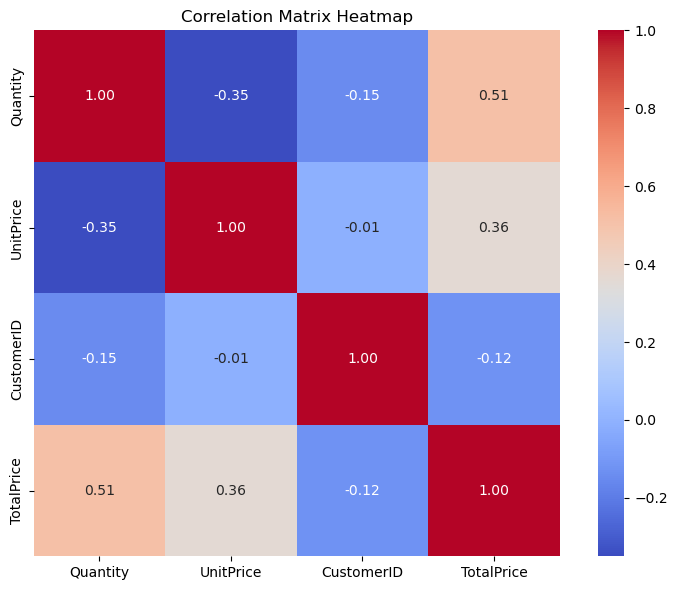

In [125]:
cov_matrix = numerical_df.cov()
corr_matrix = numerical_df.corr()

print("Covariance Matrix:")
print(cov_matrix)

print("")
print("--------------------------")
print("")

print("Correlation Matrix:")
print(corr_matrix)

print("")
print("--------------------------")
print("")

import seaborn as sns
import matplotlib.pyplot as plt

# Size of the plot
plt.figure(figsize=(8, 6))

# Correlation Matrix HeatMap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)

plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

<h2 style="color:#d36c87;">1.3. Data reduction</h2>

### Dimensionality reduction

In [126]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

# Select numeric columns
numeric_cols = ['Quantity', 'UnitPrice']
df_pca = df_cleaned[numeric_cols].copy()

# Clean data (remove NaNs or infinities)
df_pca = df_pca.replace([np.inf, -np.inf], np.nan).dropna()

# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pca)

# Applying PCA
pca = PCA(n_components=1)
principal_component = pca.fit_transform(scaled_data)

# Store/display the result
df_cleaned['PCA_1D'] = principal_component

print(f"Explained Variance by PCA component: {pca.explained_variance_ratio_[0]:.4f}")

Explained Variance by PCA component: 0.6749


In [127]:
### PCA	Simplifies feature space

### Numerosity reduction

In [128]:
numerosity_df = df_cleaned.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'PCA_1D': 'mean'  # From the PCA step
}).reset_index()

print("Numerosity reduction complete. Dataset reduced to one row per customer.")
display(numerosity_df.head())

Numerosity reduction complete. Dataset reduced to one row per customer.


,CustomerID,Quantity,UnitPrice,PCA_1D
0,12347.0,1893,2.348976,0.331216
1,12348.0,140,0.650000,2.352980
2,12349.0,523,2.607759,-0.036128
3,12350.0,196,1.581250,0.770663
4,12352.0,500,3.125152,-0.423169


### Data compression

In [129]:
# Use reduced data
compression_data = numerosity_df[['Quantity', 'UnitPrice']]

# Calc. distance and linkage
distance_matrix = pdist(compression_data)
hierarchy_linkage = linkage(distance_matrix, method='ward')

# Assigning clusters (5)
numerosity_df['Cluster'] = fcluster(hierarchy_linkage, t=5, criterion='maxclust')

print("Data compression complete. Customers assigned to 5 clusters.")
display(numerosity_df[['CustomerID', 'Cluster']].head())

Data compression complete. Customers assigned to 5 clusters.


,CustomerID,Cluster
0,12347.0,5
1,12348.0,3
2,12349.0,3
3,12350.0,3
4,12352.0,3


In [130]:
### Clustering	Compresses customer representation

<h2 style="color:#d36c87;">1.4. Data transformation and data discretization</h2>

In this part we will be identifying each category to see if there is some time of data transformation that is possible to do.

### Data Transformation

#### Data Smoothing

For this first part, the only category that shall be analyzed for such an treatment will be the UnitPrice. Let us visualize the category to take a conclusion. Since the only other category that would make sense would with time, we are using the time in the X-axis for this plot.

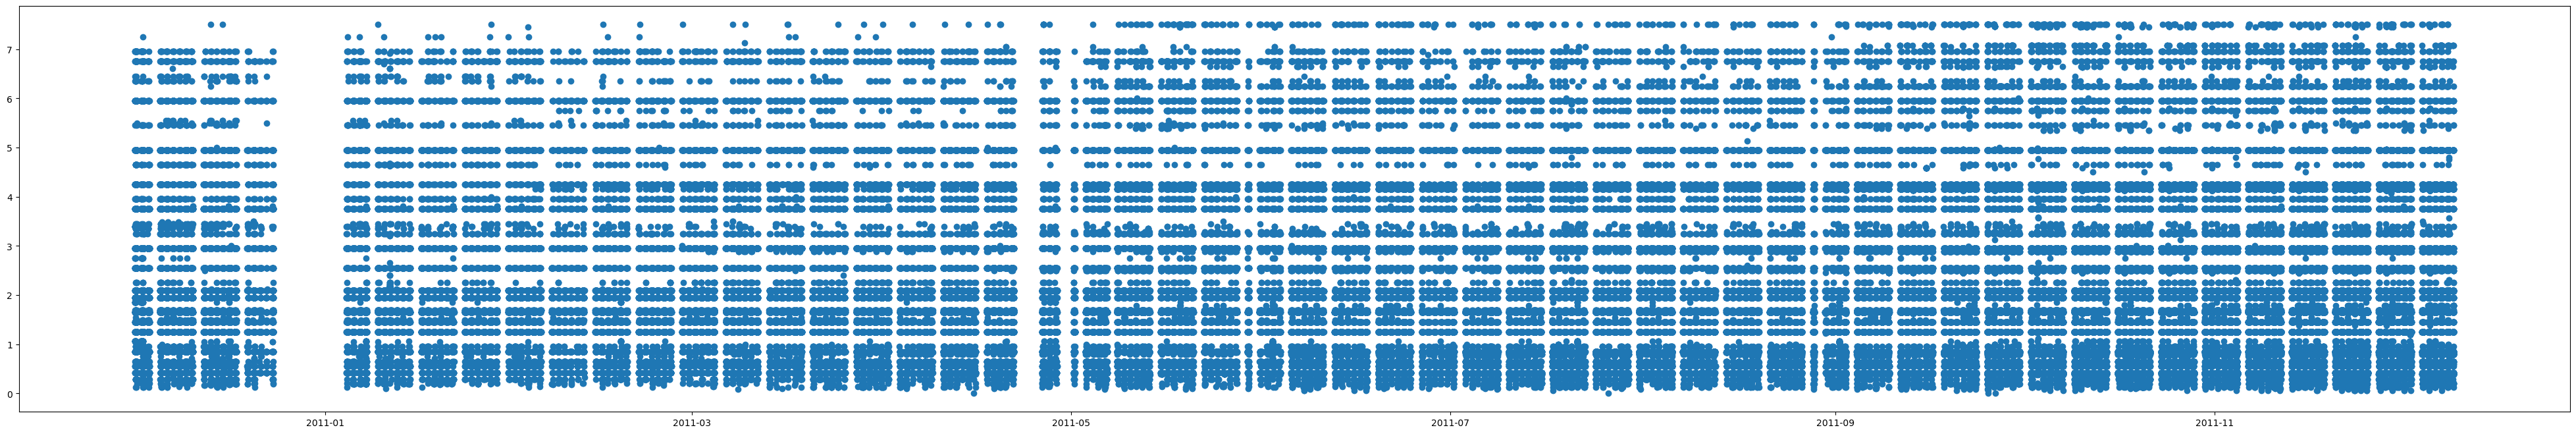

In [131]:
plt.figure(figsize=[50, 8])
plt.plot(df_cleaned['InvoiceDate'], df_cleaned['UnitPrice'], 'o')

After seeing this plot, we can clearly see that it does not make any sense to implement any smoothing algorithm since there are no appearance of any outliers. Additionally, all of the outliers have been already taken out before.

#### Data Aggregation

1. Total number of units sold by country

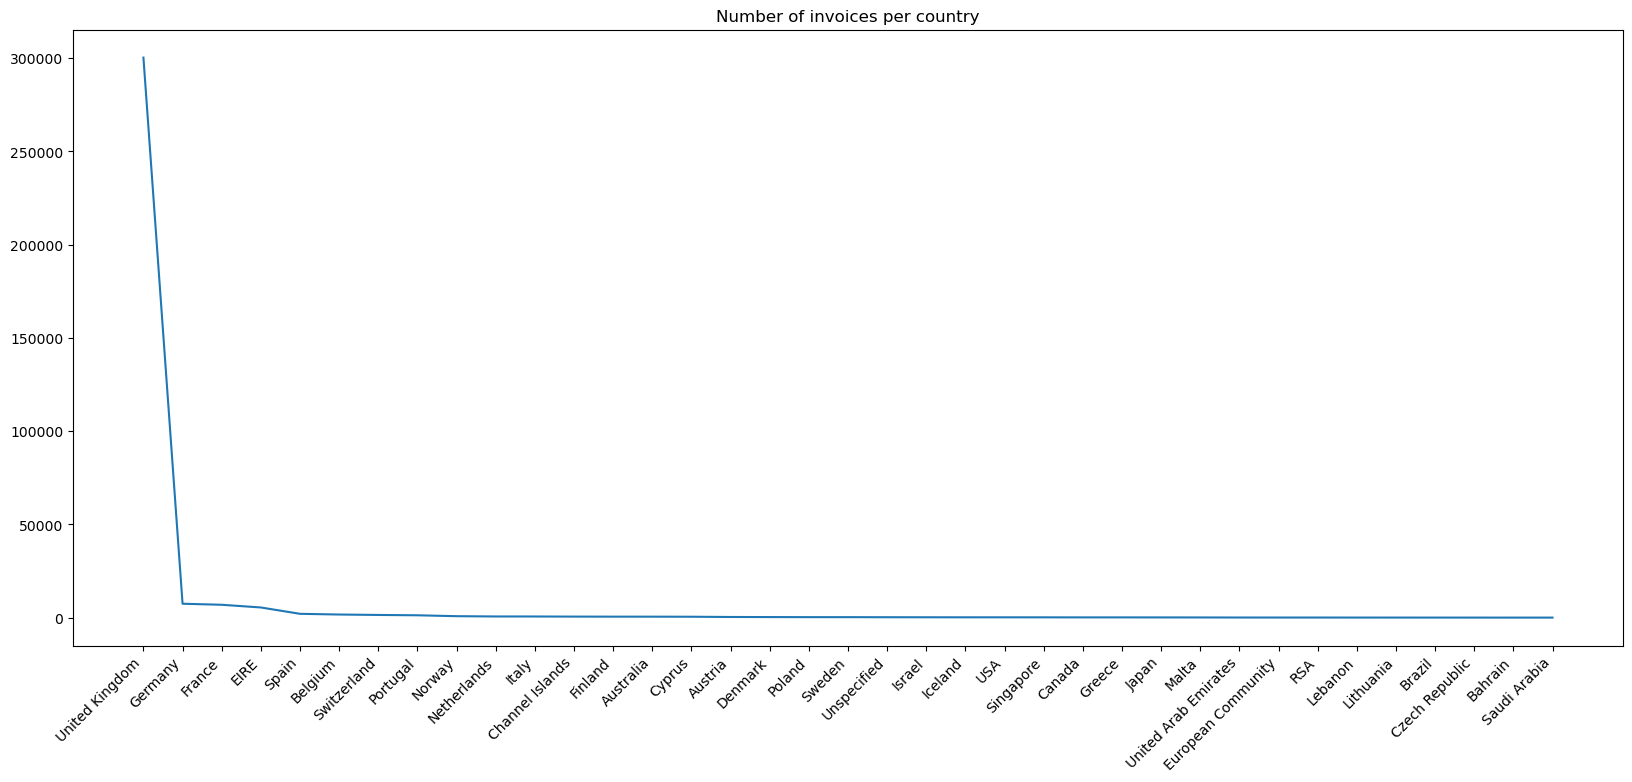

In [132]:
num_units_sold_by_country = df_cleaned.groupby('Country')['InvoiceNo'].count().sort_values(ascending=False)

plt.figure(figsize=[20, 8])
plt.xticks(rotation=45, ha='right')
plt.title("Number of invoices per country")
plt.plot(num_units_sold_by_country)


Let us now see what are the country with the least invoices.

In [133]:
#Number of total invoices
total_invoices = len(np.unique(df_cleaned['InvoiceNo']))
#Setting a limit
limit = total_invoices/100

#Printing new plot
active_countries = num_units_sold_by_country[num_units_sold_by_country>=limit].index

print("Number of countries before filtering:", len(num_units_sold_by_country))
print("Number of items sold before: ", num_units_sold_by_country.sum())
print("Filtering all countries that have less that 1 percent of the total sales...")
print("Number of countries after filtering:", len(active_countries))
print("Number of items sold after: ", num_units_sold_by_country[active_countries].sum())

Number of countries before filtering: 37
Number of items sold before:  333234
Filtering all countries that have less that 1 percent of the total sales...
Number of countries after filtering: 21
Number of items sold after:  332030


Since there are clearly a lot of countries that do not contribute much to the whole dataset and could bring some undesired patterns, it is better to remove those countries from the dataset.

In [134]:
transformed_data = df_cleaned[df_cleaned['Country'].isin(active_countries)]

2. Number of costumers per country

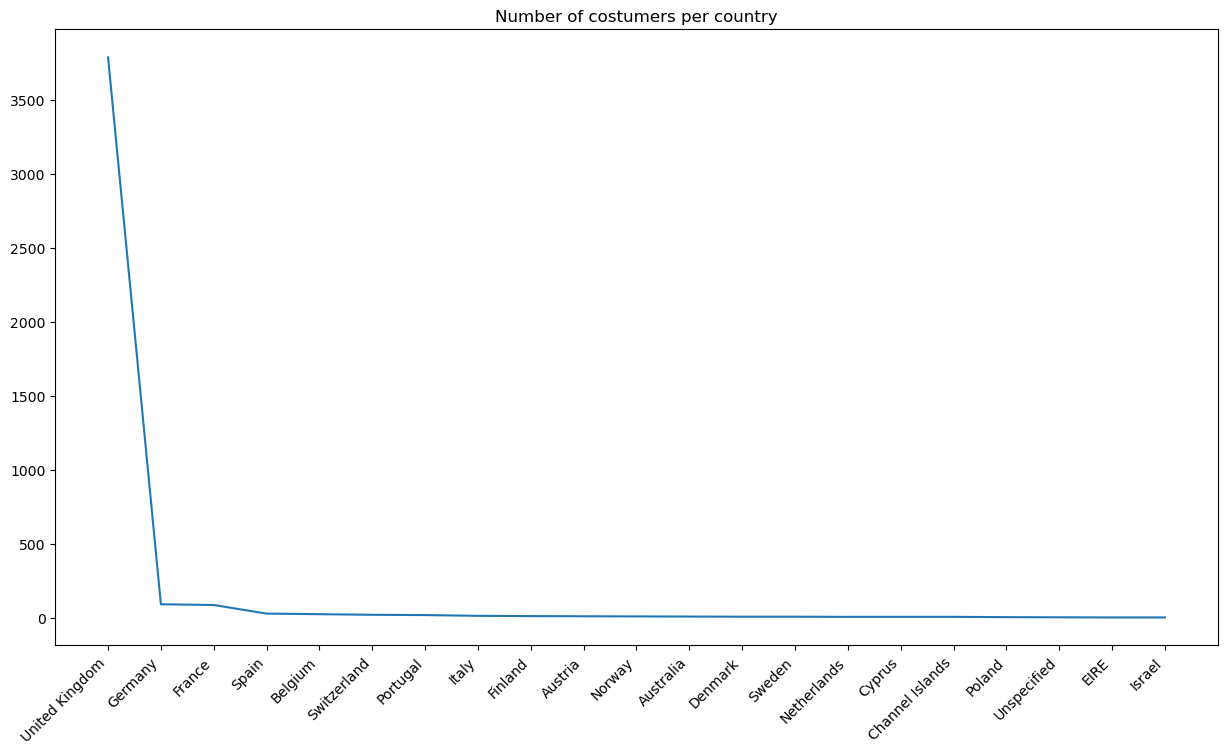

In [135]:
num_custumers_per_country = transformed_data.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False)

plt.figure(figsize=[15,8])
plt.title("Number of costumers per country")
plt.xticks(rotation=45, ha='right')
plt.plot(num_custumers_per_country)

Let us see of there are any countries that have a considerable amount of low costumers.

In [136]:
total_costumers = len(np.unique(transformed_data['CustomerID']))
costumers_limit = total_costumers/200 #Limit is 0.5 %

active_costumers = num_custumers_per_country[num_custumers_per_country >= costumers_limit].index
print("Number of countries before filtering:", len(num_custumers_per_country))
print("Number of total costumers before: ", num_custumers_per_country.sum())
print("Filtering all countries that have less that 1 percent of the total sales...")
print("Number of countries after filtering:", len(active_costumers))
print("Number of total invoices after: ", num_custumers_per_country[active_costumers].sum())

Number of countries before filtering: 21
Number of total costumers before:  4165
Filtering all countries that have less that 1 percent of the total sales...
Number of countries after filtering: 6
Number of total invoices after:  4038


Since there are clearly a lot of countries that do not have many costumers compared to the whole dataset and could bring some undesired patterns, it is better to remove those countries from the dataset.

In [137]:
transformed_data = transformed_data[transformed_data['Country'].isin(active_costumers)]

3. Sales over time (Monthly)

Month
2010-12    20935
2011-01    16856
2011-02    15683
2011-03    21352
2011-04    18226
2011-05    22367
2011-06    21247
2011-07    21252
2011-08    21301
2011-09    32602
2011-10    40156
2011-11    53486
2011-12    14289
Freq: M, Name: InvoiceNo, dtype: int64


<Axes: title={'center': 'Number of invoices per month'}, xlabel='Month'>

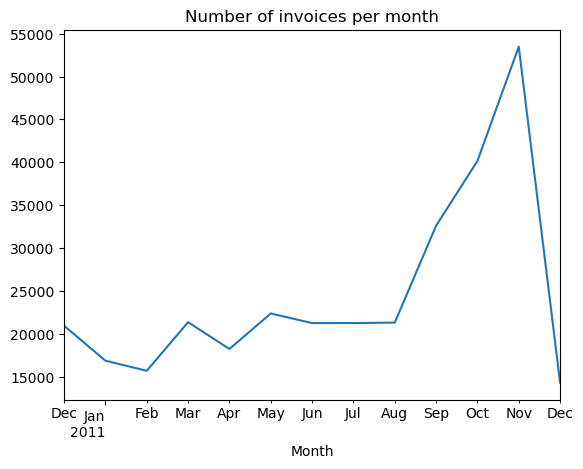

In [138]:
transformed_data['InvoiceDate'] = pd.to_datetime(transformed_data['InvoiceDate'])
transformed_data['Month'] = transformed_data['InvoiceDate'].dt.to_period('M')
transformed_data['Week'] = transformed_data['InvoiceDate'].dt.to_period('W')

monthly_sales = transformed_data.groupby(['Month'])['InvoiceNo'].count()
print(monthly_sales)

plt.xticks(rotation=45, ha='right')
plt.title("Number of invoices per month")
monthly_sales.plot()

Here, we can clearly see that that is a peek in sales during the final months of the year.

Let us now study the sales per day of the week.

<Axes: title={'center': 'Number of invoices per day of the week'}, xlabel='Day'>

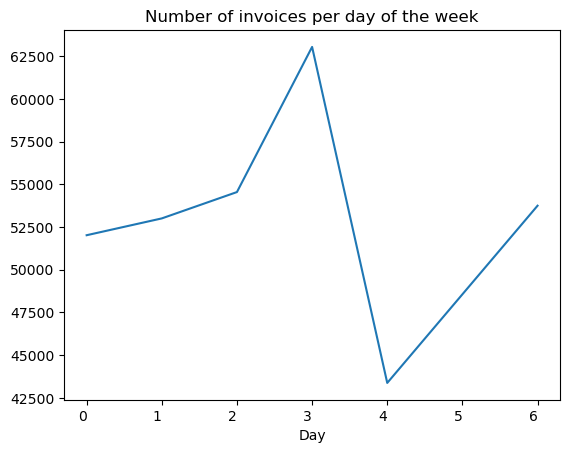

In [139]:

transformed_data['Day'] = transformed_data['InvoiceDate'].dt.weekday

day_sales = transformed_data.groupby(['Day'])['InvoiceNo'].count()


plt.xticks(rotation=45, ha='right')
plt.title("Number of invoices per day of the week")
day_sales.plot()

Here we can also see that on the day three we have a peek of sales, this being on thursday.

#### Data Normalization

For this model, we decided to not do any data normalization, this because we rather work with raw values since it will be more about doing a business analysis than training a model for example.

#### Data Discretization

Let's start by binning the UnitPrice since it is the more obvious approach here.

In [140]:
transformed_data['UnitPriceBin'] = pd.cut(transformed_data['UnitPrice'], bins = 5)

#Costumer spend
customer_spend = transformed_data.groupby('CustomerID')['TotalPrice'].sum()
transformed_data['SpendLevel'] = pd.qcut(transformed_data['CustomerID'].map(customer_spend), q=4, labels=['Low', 'Med', 'High', 'Very High'])
transformed_data['GeneralCountry'] = np.where(transformed_data['Country'] == 'United Kingdom', 'United Kingdom', 'Others')



#Other ideas
    #Countries (In and out of UK)
    # # of items purchased -> should be discussed in the future
    #...


# Saving the Csv file
transformed_data.to_csv("Dataset_Online_Retail_Cleaned_Transformed.csv", index=False)

print("Showing first 5 elements")
transformed_data.tail()

Showing first 5 elements


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,PCA_1D,Month,Week,Day,UnitPriceBin,SpendLevel,GeneralCountry
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,1.079034,2011-12,2011-12-05/2011-12-11,4,"(-0.0065, 1.501]",Low,Others
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,-0.118698,2011-12,2011-12-05/2011-12-11,4,"(1.501, 3.001]",Low,Others
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,-1.264988,2011-12,2011-12-05/2011-12-11,4,"(3.001, 4.5]",Low,Others
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,-1.264988,2011-12,2011-12-05/2011-12-11,4,"(3.001, 4.5]",Low,Others
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85,-1.735223,2011-12,2011-12-05/2011-12-11,4,"(4.5, 6.0]",Low,Others


---
# 2. Data Visualization

<h2 style="color:#d36c87;">2.1. Services</h2>

### Grand level (Charlie)

What to do:

- Box plots with all numerical variables (Quantity, UnitPrice)

- Can also do some with totalPrice

In [141]:
#Code for Charlie

### Countries

1. World Map

In [142]:
import plotly.express as px
import pycountry

sales_per_country = (
    transformed_data.groupby('Country')['TotalPrice']
    .sum()
    .reset_index()
    .rename(columns={'TotalPrice': 'TotalSales'})
)

total_sales = sales_per_country['TotalSales'].sum()
sales_per_country['SalesPercentage'] = (sales_per_country['TotalSales'] / total_sales) * 100

def country_to_iso3(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None

sales_per_country['iso_alpha'] = sales_per_country['Country'].apply(country_to_iso3)
sales_per_country = sales_per_country.dropna(subset=['iso_alpha'])

min_val = sales_per_country['SalesPercentage'].min()
max_val = sales_per_country['SalesPercentage'].max()

range_min = min_val
range_max = max_val

fig = px.choropleth(
    sales_per_country,
    locations='iso_alpha',
    color='SalesPercentage',
    hover_name='Country',
    hover_data={'SalesPercentage': True, 'Country': True},
    title='Sales Distribution by Country (%)',
    color_continuous_scale='YlGnBu',  # Use YlGnBu color scale
    range_color=(range_min, range_max)
)

fig.update_traces(colorbar_tickformat='%{value:.1f}')

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    coloraxis_colorbar=dict(
        title="% of Total Sales",
        ticksuffix='%',
    ),
    showlegend=False
)

fig.show()

sales_table = sales_per_country[['Country', 'SalesPercentage']].sort_values(by='SalesPercentage', ascending=False)
print(sales_table)

          Country  SalesPercentage
5  United Kingdom        91.376619
2         Germany         3.424370
1          France         3.027996
3           Spain         0.740422
4     Switzerland         0.739516
0         Belgium         0.691076


2. Sales Share: UK vs Others

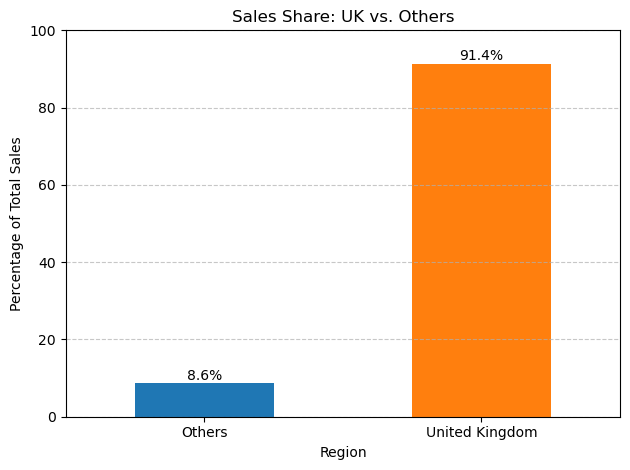

In [143]:
sales_by_region = transformed_data.groupby('GeneralCountry')['TotalPrice'].sum()

sales_percent = (sales_by_region / sales_by_region.sum()) * 100

colors = ['#1f77b4', '#ff7f0e']  # UK in blue, Others in orange
sales_percent.plot(kind='bar', color=colors)

plt.title('Sales Share: UK vs. Others')
plt.ylabel('Percentage of Total Sales')
plt.xlabel('Region')
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(sales_percent):
    plt.text(i, value + 1, f"{value:.1f}%", ha='center')

plt.tight_layout()
plt.show()

### Sold Items

1. Number of sold items per country

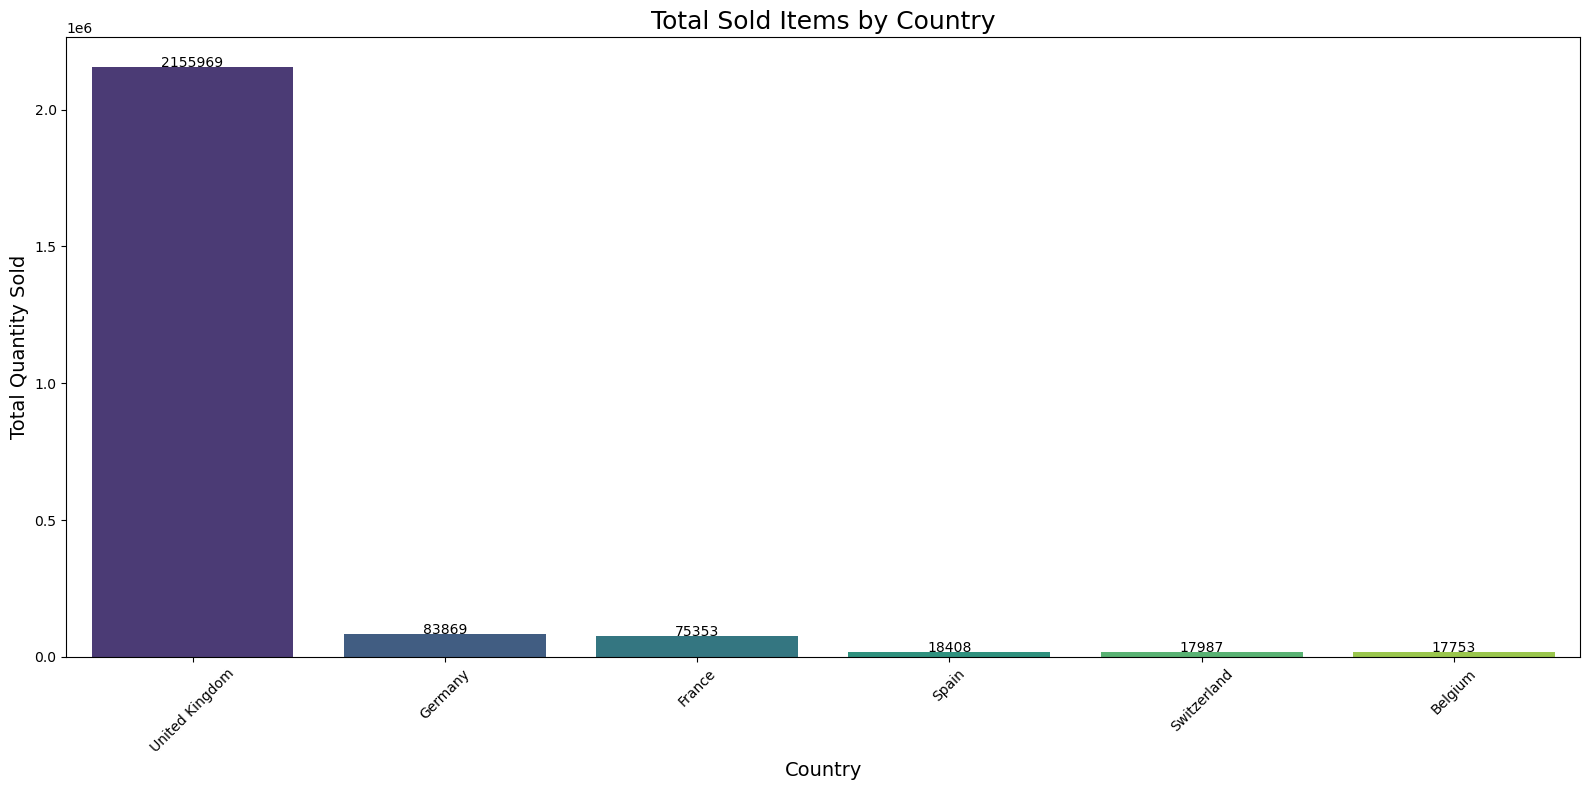

In [144]:
import seaborn as sns

sold_items_by_country = transformed_data.groupby('Country')['Quantity'].sum().reset_index()
sold_items_by_country = sold_items_by_country.sort_values('Quantity', ascending=False)

plt.figure(figsize=(16, 8))
ax = sns.barplot(
    x='Country',
    y='Quantity',
    hue='Country',
    data=sold_items_by_country,
    dodge=False,
    palette='viridis',
    legend=False
)

for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 50,
        f'{int(bar.get_height())}',
        ha='center'
    )

ax.set_title('Total Sold Items by Country', fontsize=18)
ax.set_ylabel('Total Quantity Sold', fontsize=14)
ax.set_xlabel('Country', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2. The 10 most sold items as well as the number of sales

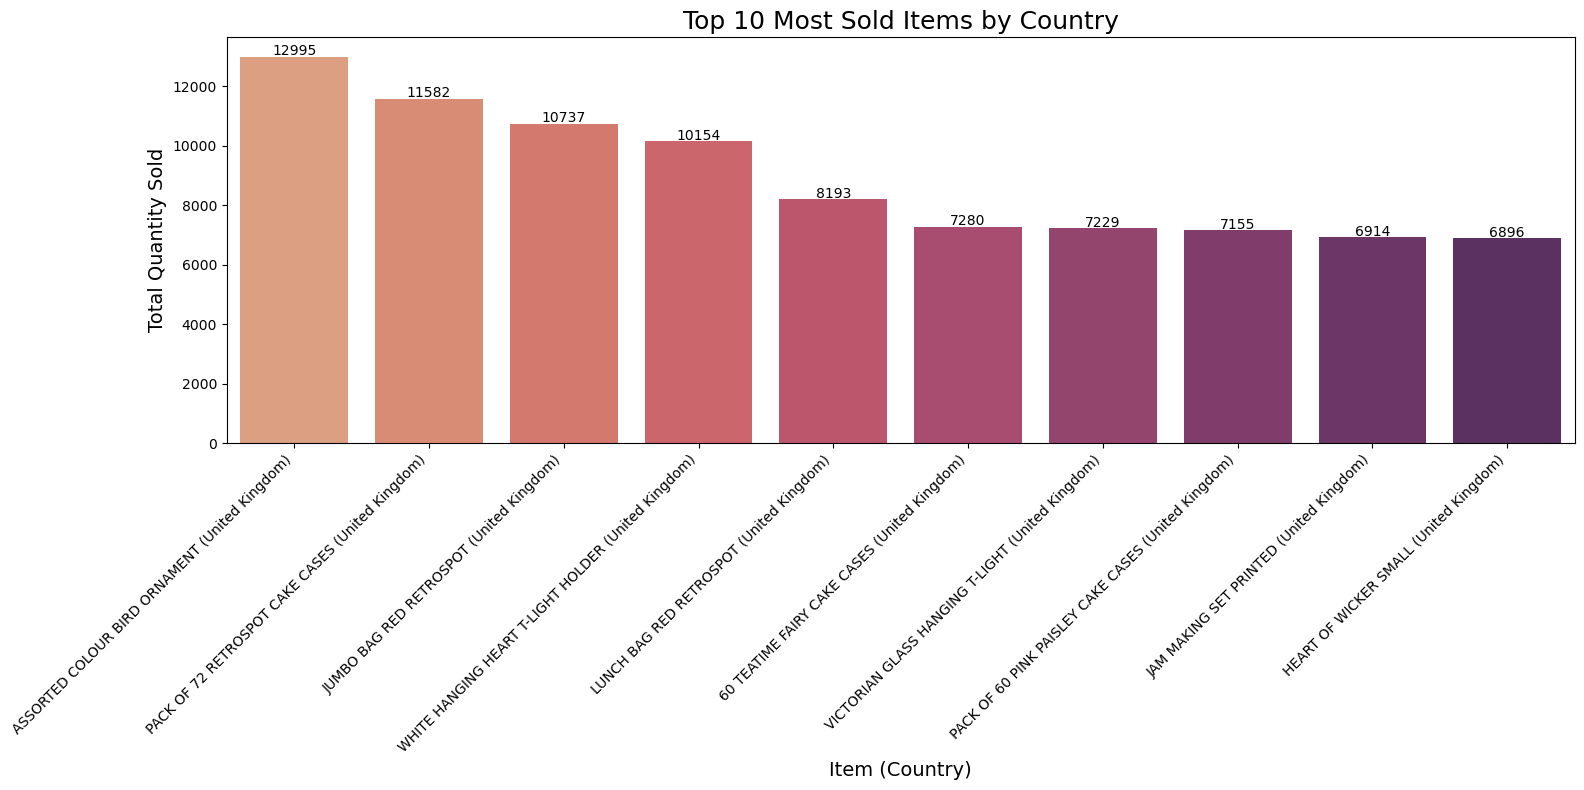

In [145]:
top_items_country = (
    transformed_data
    .groupby(['Description', 'Country'])['Quantity']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

top_items_country['Label'] = top_items_country['Description'] + ' (' + top_items_country['Country'] + ')'

plt.figure(figsize=(16, 8))
ax = sns.barplot(
    x='Label',
    y='Quantity',
    hue='Label',
    data=top_items_country,
    dodge=False,
    palette='flare',
    legend=False
)

for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 50,
        f'{int(bar.get_height())}',
        ha='center'
    )

ax.set_title('Top 10 Most Sold Items by Country', fontsize=18)
ax.set_ylabel('Total Quantity Sold', fontsize=14)
ax.set_xlabel('Item (Country)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<h2 style="color:#d36c87;">2.2. Clients</h2>

### Clients / sales (André)

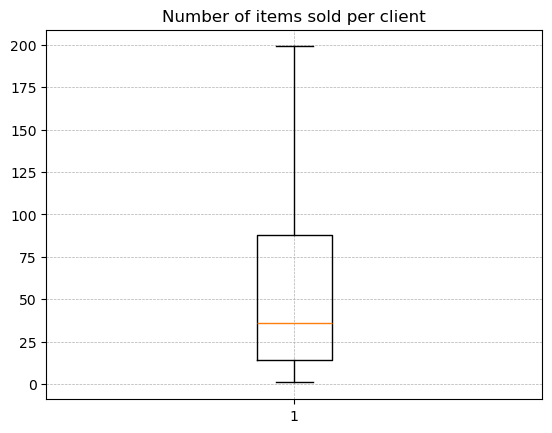

In [146]:
#Code for Andre

#Getting all invoices
customer_number_items = transformed_data.groupby('CustomerID')['InvoiceNo'].count()

plt.title('Number of items sold per client')
plt.boxplot(customer_number_items, sym= '')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)


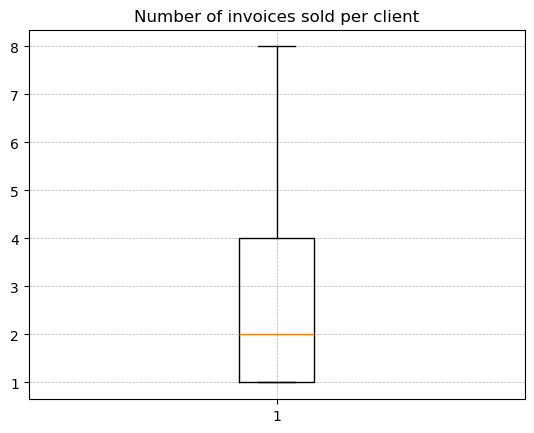

In [147]:
# Visualizing the number of invoices per client

customer_number_invoices_array = transformed_data.groupby('CustomerID')['InvoiceNo'].unique()
customer_number_invoices = np.zeros(len(customer_number_invoices_array))
counter = 0

for i in customer_number_invoices_array:
    numOfInvoices = len(i)
    customer_number_invoices[counter] = numOfInvoices
    counter += 1

plt.title('Number of invoices sold per client')
plt.boxplot(customer_number_invoices, sym= '')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

### Sales / time (André)

<Axes: title={'center': 'Number of invoices per week'}, xlabel='Week'>

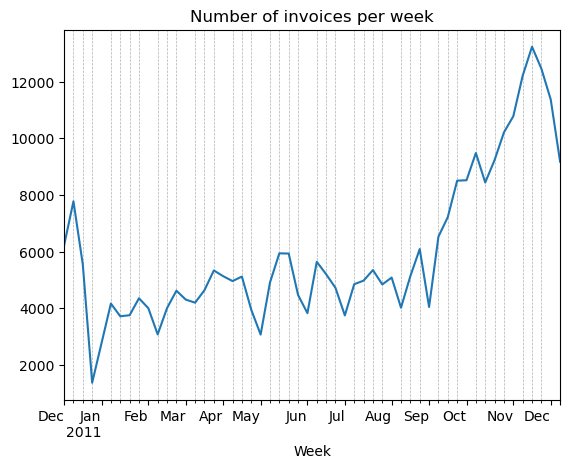

In [148]:
#Code for Andre

weekly_sales = transformed_data.groupby(['Week'])['InvoiceNo'].count()
plt.xticks(rotation=45, ha='right')
plt.title("Number of invoices per week")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
weekly_sales.plot()


C:\Users\Andre\AppData\Local\Temp\ipykernel_70748\1424278215.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: title={'center': 'Number of invoices per week during november and december'}, xlabel='Day'>

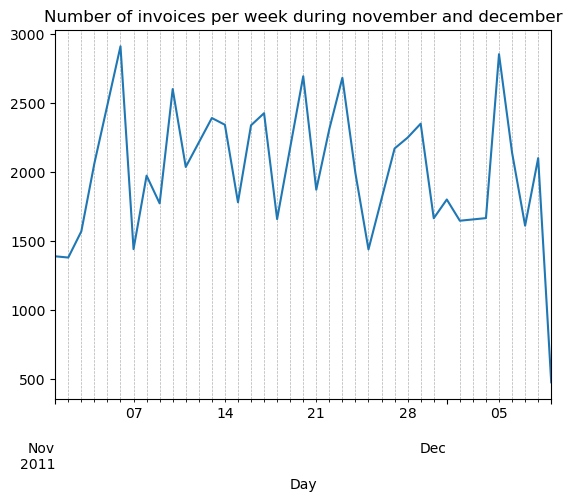

In [149]:
# Analyzing the months with more sales
mask = (transformed_data['Month'] >= pd.Period('2011-11')) & (transformed_data['Month'] <= pd.Period('2011-12'))

big_sales_sub_group = transformed_data[mask]
big_sales_sub_group['Day'] = big_sales_sub_group['InvoiceDate'].dt.to_period('D')
weekly_big_sales = big_sales_sub_group.groupby(['Day'])['InvoiceNo'].count()

plt.xticks(rotation=45, ha='right')
plt.title("Number of invoices per week during november and december")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
weekly_big_sales.plot()

### Expenses (Charlie)

What to do:

- Pie chart about "SepndLevel"

- Some other ideas that could pop up in your mind

In [150]:
#Code for Charlie